For plots in Figure 3c and Supplementary Fig. S9.

There are three types of plots:
1. Coverage plots (percent of a region overlaps with a specific feature)
2. Density plots (number of features in a specific window)
3. Read mapping densities

## Getting the data

In [2]:
#This part is to access functions in custom_scripts folder
custom_script_dir = "../custom_scripts/"
import sys
sys.path.insert(0,custom_script_dir)

import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# The below are functions from custom_scripts
import cov_densities as cov

In [3]:
fasta = "/home/Pam/submissions/repeats/Nara/Nara.fsa"
genomefile = "../additional_data/Nara/Nara.genome"
window = 10000

#Make a bedtools genome file if one doesn't exist
cov.make_genomefile(fasta,genomefile)

This could all be done directly with bedtools coverage rather than pybedtools as shown here.

In [4]:
#For coverage and density plots
#Import all genes into a dataframe -- this is input for get_goi_loc
allgenesdf = cov.import_genegff("../additional_data/Nara/Nara.gene.gff")

#Prepare pybedtools object of only specific genes given in lists
EPbed = cov.get_goi_loc(allgenesdf,"../additional_data/Nara/Nara.effectorP.list")
UPbed = cov.get_goi_loc(allgenesdf,"../additional_data/Nara/Nara.inplanta.DEup.list")

#Run bedtools coverage for genes, TEs (non-simple repeats), effectorP-predicted genes, in planta up-regulated genes, 
#telomeric repeats and accessory regions.
genecov = cov.genomewide_cov(genomefile,window,feature="../additional_data/Nara/Nara.gene.gff")
TEcov = cov.genomewide_cov(genomefile,window,feature="../additional_data/Nara/Nara.repeatmasker.parsed.gff")
EPcov = cov.genomewide_cov(genomefile,window,feature=EPbed)
UPcov = cov.genomewide_cov(genomefile,window,feature=UPbed)
telrepcov = cov.genomewide_cov(genomefile,window,feature="../additional_data/Nara/Nara.subtel.gff")
accessory = cov.genomewide_cov(genomefile,window,feature="../additional_data/Nara/Nara.accessory.regions.merge.bed")

#For the TpA/ApT ratios, import output of dinucleotide_freq_count.py
dintfreq = pd.read_csv("../additional_data/Nara/Nara.dint.freq.csv")
dintfreq = dintfreq.rename(columns={"seq_id": "chr"})
dintfreq["TpA/ApT"] = dintfreq["TA"]/dintfreq["AT"]

In [5]:
#For read depth heatmap
#Inputs are from bedtools coverage (see:../docs/Remapping.md). While this could also be done with pybedtools, 
#combining bedtools coverage with gnu parallel speeds up the process by allowing parallel calculations.
def import_bedcov_depth_from_file(bedfile,prefix,suffix):
    prelen = len(prefix)
    suflen = len(suffix)
    strain = bedfile[prelen:-suflen]
    straindf = pd.read_csv(bedfile,header=None,sep="\t",names=["chr","start","end","depth","n_bp","len","cov"])
    straindf[strain]=straindf["depth"]/straindf["len"]
    med = straindf[strain].median()
    straindf[strain] = (straindf[strain]/med)
    straindf["mid"] = (straindf["start"]+straindf["end"])/2
    straindf = straindf[["chr","start","end","mid",strain]]
    return straindf

def scale(x):
    #Apply a log10 scale to the read depths with a prior count of 1
    logscale = np.log10(x+1)
    return logscale


In [6]:
#Import bedtools coverage output files into a single dataframe. 
#Here outputs were generated with bedtools coverage before analysis.
prefix = "/home/Pam/submissions/remapping/Nara/"
suffix = ".Nara.10k.bedtoolscoverage.bed"
bedlist = glob.glob(prefix+"*"+suffix)


depthdf = import_bedcov_depth_from_file(bedlist[0],prefix,suffix)
for i in range(1,len(bedlist)):
    df = import_bedcov_depth_from_file(bedlist[i],prefix,suffix)
    newdf = pd.merge(depthdf,df,on=["chr","mid","start","end"])
    depthdf = newdf


In [7]:
#Rearrange according and log transform using the function created above
logdepth = depthdf[["chr","mid","start","end","S1","S4","413","245","415","Cg363","CAD5","CAD1","CAD2","CAD4","Cg56","CglS","CGW01"]].copy()
logdepth[["S1","S4","413","245","415","Cg363","CAD5","CAD1","CAD2","CAD4","Cg56","CglS","CGW01"]] = depthdf[["S1","S4","413","245","415","Cg363","CAD5","CAD1","CAD2","CAD4","Cg56","CglS","CGW01"]].apply(scale)

## Plotting the data

In [4]:
def plot_data(axn, adf,contigs,miny,maxy,linecolor,yvalue,linevalue):
    if linevalue is None:
        line = np.mean(adf[yvalue])
    else:
        line = linevalue
    df=adf[adf["chr"]==contigs]
    df=df.reset_index()
    y= np.full((df.shape[0], 1), line)
    axn.plot(df["mid"],df[yvalue],linewidth=0.5,color=linecolor,alpha=1)
    axn.plot(df["mid"],y,linewidth=0.5,color="lightgray")
    axn.set_ylim(0,maxy)
    axn.set_xlim(0,max(df["mid"]))
    axn.set_xticks([])
    axn.fill_between(df["mid"],df[yvalue],y2=0,color=linecolor,alpha=1)
    axn.grid(False)
    
def plot_data2(axn,adf,contigs,miny,maxy,linecolor,yvalue,linevalue,positive_color,negative_color):
    df=adf[adf["chr"]==contigs]
    df=df.reset_index()
    if linevalue is None:
        line = np.mean(adf[yvalue])
        axn.fill_between(df["mid"],df[yvalue],y2=line,color=linecolor,alpha=1)
    else:
        line = linevalue
        df[yvalue+"pos"] = df[yvalue]
        df[yvalue+"pos"].loc[df[yvalue]<linevalue] = linevalue
        df[yvalue+"neg"] = df[yvalue]
        df[yvalue+"neg"].loc[df[yvalue]>=linevalue] = linevalue      
        axn.fill_between(df["mid"],df[yvalue+"pos"],y2=line,color=positive_color,alpha=1)
        axn.fill_between(df["mid"],df[yvalue+"neg"],y2=line,color=negative_color,alpha=1)
    y= np.full((df.shape[0], 1), line)
    axn.plot(df["mid"],df[yvalue],linewidth=0.5,color=linecolor,alpha=1)
    axn.plot(df["mid"],y,linewidth=0.5)
    axn.set_ylim(0,maxy)
    axn.set_xlim(0,max(df["mid"]))
    axn.set_xticks([])
    axn.grid(False)
    
def format_func(value, tick_number):
    # find number of multiples of pi/2
    N = float(np.divide(value,100))
    return r"{0}".format(N)
      
def plot_imshow(axn,adf,contig):
    df=adf[adf["chr"]==contig]
    df.index=np.divide(df.mid,1000000)
    df.drop(["chr","start","end","mid"], axis=1, inplace=True)
    df=np.transpose(df)
    axn.imshow(df,vmin=0,vmax=0.6,aspect="auto")
    axn.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axn.xaxis.tick_top() 

In [9]:
df = pd.read_csv(genomefile,sep="\t",names=["chr","len"])
contigs = df["chr"].to_list()
lengths = df["len"].to_list()

/home/Pam/bin/anaconda3/envs/pybedtools/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/Pam/bin/anaconda3/envs/pybedtools/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/Pam/bin/anaconda3/envs/pybedtools/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

/home/Pam/bin/anaconda3/envs/pybedtools/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/Pam/bin/anaconda3/envs/pybedtools/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


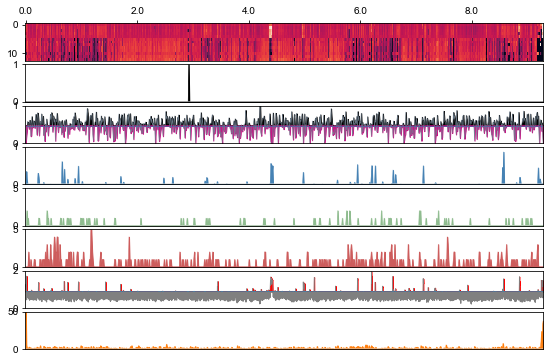

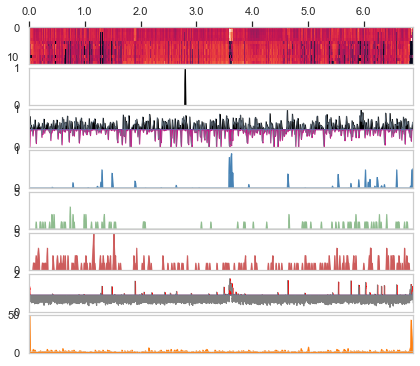

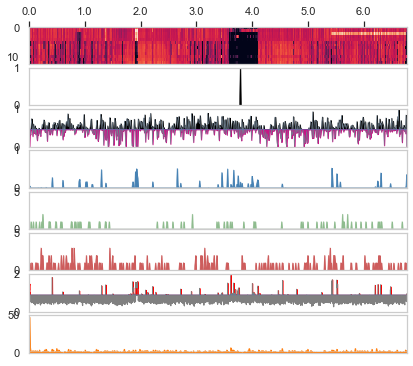

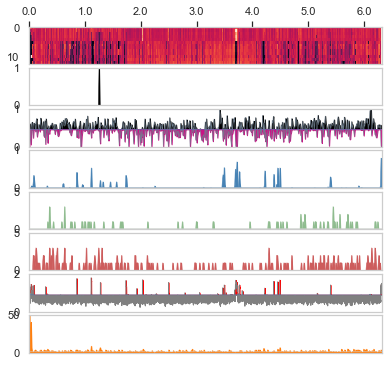

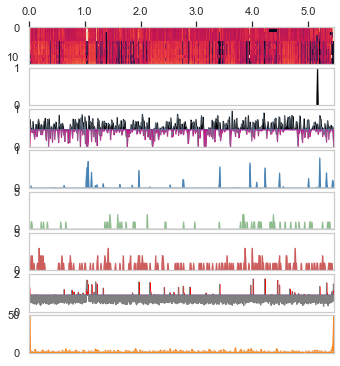

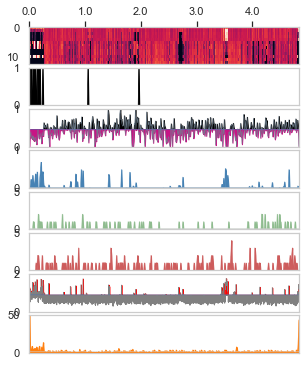

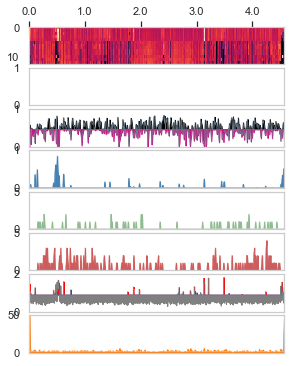

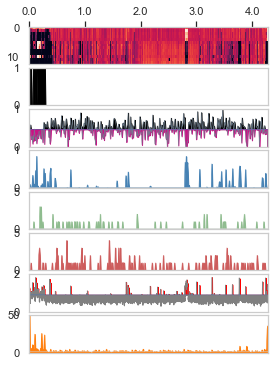

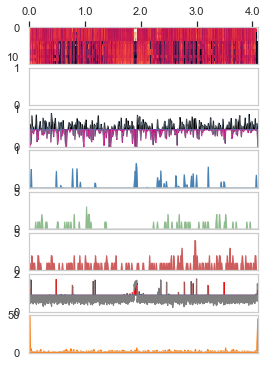

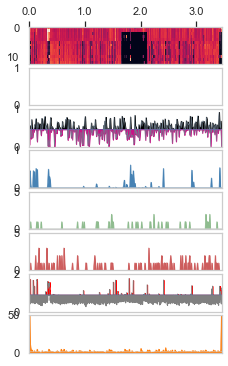

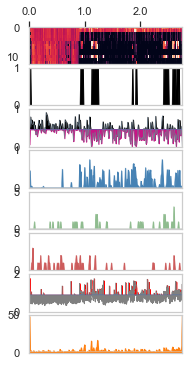

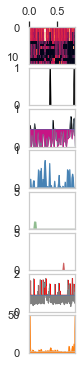

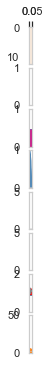

In [42]:
for contig in contigs:
    i = contigs.index(contig)
    #The width of the figure will be adjusted according to the length of the sequence (in bp)
    fwidth = int(lengths[i])/1000000
    fig,(axs) = plt.subplots(nrows=8,ncols=1,figsize=(fwidth,6))
    sns.set()
    sns.set_style("whitegrid")

    #heatmap of depth
    plot_imshow(axs[0],logdepth,contig)
    axs[0].grid(False)
    
    #accessory regions
    plot_data(axs[1],accessory,contig,0,1,"black","count",None)
    
    #gene coverage
    genedfav = np.mean(genecov["cov"])
    plot_data2(axs[2],genecov,contig,0,1,"slategray","cov",genedfav,"black","mediumvioletred")

    #TE coverage
    plot_data(axs[3],TEcov,contig,0,1,"steelblue","cov",None)
    
    #EffectorP numbers/10 kb window
    plot_data(axs[4],EPcov,contig,0,5,"darkseagreen","count",None)
    
    #In planta up-regulated/10 kb window
    plot_data(axs[5],UPcov,contig,0,5,"indianred","count",5)
    
    #TpA/ApT
    plot_data2(axs[6],dintfreq,contig,0,2,"gray","TpA/ApT",0.89,"red","gray")
    
    #Telomeric repeats
    plot_data(axs[7],telrepcov,contig,0,50,"tab:orange","count",None)
    
    plt.subplots_adjust(wspace=0, hspace=0.1)
    filename = contig+".cov.pdf"
    fig.savefig(filename,format="pdf")

## For read mapping density line plots

For plots in Fig 5B and Supplementary Figure S6C.

After mapping with bowtie and running bedtools coverage:

In [3]:
#Import bedtools coverage output files into a single dataframe
prefix = "/home/Pam/submissions/remapping/Nara/20200113_bedcoverage/Nara_c06/"
suffix = ".Nara_c06.sort.bed"

#List of bedtools coveage files -> 100 bp windows across whole of Nara_c06
#Nara, S1, Cg56, Cg363 are ngmlr-mappings of PacBio reads. S4, CAD1 and CAD5 were mapped with 
#bowtie2.
bedlist = glob.glob(prefix+"*"+suffix)

c06depth = import_bedcov_depth_from_file(bedlist[0],prefix,suffix)
for i in range(1,len(bedlist)):
    df = import_bedcov_depth_from_file(bedlist[i],prefix,suffix)
    newdf = pd.merge(c06depth,df,on=["chr","mid","start","end"])
    c06depth = newdf

NameError: name 'import_bedcov_depth_from_file' is not defined

In [1]:
plt.figure(figsize=[20,4])
plt.ylim(0,40)
plt.xlim(58662,213072)

strains = ["Nara","S1","S4","Cg56","Cg363","CAD1","CAD5"]
colors = ["red","red","red","green","blue","blue","blue"]
linestyles = ["--",":","-","--","--",":","-"]
alphas = [0.8,0.6,0.4,0.8,0.8,0.6,0.2]

#Normalized over median depth from 2-4 Mb.Based on the heatmaps this should be 1x coverage.
for i in range(len(strains)):
    r = c06depth[strains[i]]/c06depth[(c06depth["mid"]>2000000)&(c06depth["mid"]<4000000)][strains[i]].median()
    ax = plt.plot(c06depth["mid"],r,linestyle=linestyles[i],color=colors[i],alpha=alphas[i],label=strains[i])

ax = plt.axhline(y=1,linestyle=":",color="black")
ax = plt.axhline(y=11,linestyle="--",color="black")
plt.grid(False)
plt.ylabel("Normalized depth")
plt.xlabel("Nara_c06")
plt.legend(loc="upper right",fontsize=8)
plt.show()

plt.savefig("Nara_c06_CGSC_accessory_regions.pdf",format="pdf")

NameError: name 'plt' is not defined

In [41]:
%%bash
pwd

/home/Pam/bin/colletotrichum_genome/github_repo/colletorichum_genome/jupyter_notebooks


In [7]:
#Import bedtools coverage output files into a single dataframe
prefix = "/home/Pam/submissions/remapping/CF413/whole_genome/"
suffix = ".wg.bed"

#List of bedtools coveage files -> 100 bp windows across whole of Nara_c06
#Nara, S1, Cg56, Cg363 are ngmlr-mappings of PacBio reads. S4, CAD1 and CAD5 were mapped with 
#bowtie2.
bedlist = glob.glob(prefix+"*"+suffix)

wg = import_bedcov_depth_from_file(bedlist[0],prefix,suffix)
for i in range(1,len(bedlist)):
    df = import_bedcov_depth_from_file(bedlist[i],prefix,suffix)
    newdf = pd.merge(wg,df,on=["chr","mid","start","end"])
    wg = newdf
wg.head()

,chr,start,end,mid,245,415,413,Nara,S1,S4
0,413_c01,0,10000,5000.0,2.095858,6.107375,0.368421,0.268817,0.078947,2.291443
1,413_c01,10000,20000,15000.0,0.785141,1.121645,0.590226,1.584229,1.736842,1.137328
2,413_c01,20000,30000,25000.0,1.003682,0.953498,0.672932,0.810036,1.500000,1.330069
3,413_c01,30000,40000,35000.0,1.140565,1.116356,0.691729,0.799283,1.078947,1.183804
4,413_c01,40000,50000,45000.0,1.005917,1.005289,0.781955,0.817204,1.342105,1.037382


In [6]:
#Import bedtools coverage output files into a single dataframe
prefix = "/home/Pam/submissions/remapping/CF413/CF413_c09/"
suffix = ".c09.bed"

#List of bedtools coveage files -> 100 bp windows across whole of Nara_c06
#Nara, S1, Cg56, Cg363 are ngmlr-mappings of PacBio reads. S4, CAD1 and CAD5 were mapped with 
#bowtie2.
bedlist = glob.glob(prefix+"*"+suffix)

c09depth = import_bedcov_depth_from_file(bedlist[0],prefix,suffix)
for i in range(1,len(bedlist)):
    df = import_bedcov_depth_from_file(bedlist[i],prefix,suffix)
    newdf = pd.merge(c09depth,df,on=["chr","mid","start","end"])
    c09depth = newdf
c09depth.head()

,chr,start,end,mid,245,415,413,Nara,S1,S4
0,413_c09,0,10000,5000.0,0.936005,4.539091,0.126812,0.043321,0.081081,1.275346
1,413_c09,1000,11000,6000.0,1.007473,4.278994,0.123188,0.039711,0.081081,1.374477
2,413_c09,2000,12000,7000.0,0.874592,3.622454,0.134058,0.054152,0.054054,1.259092
3,413_c09,3000,13000,8000.0,0.851495,3.440284,0.152174,0.061372,0.081081,1.197136
4,413_c09,4000,14000,9000.0,0.815353,3.143713,0.155797,0.086643,0.081081,1.112005


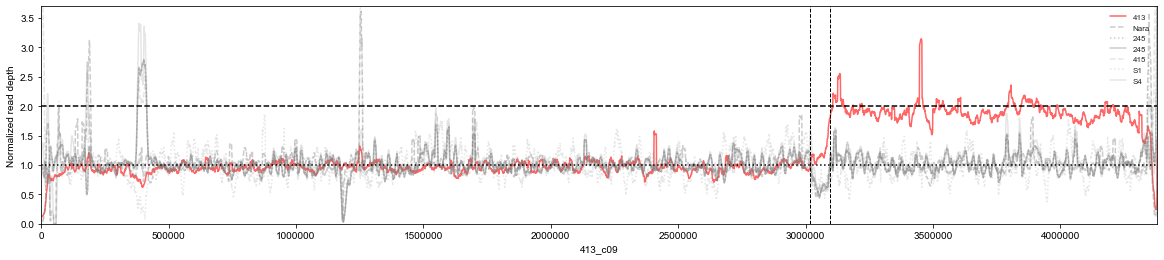

In [8]:
plt.figure(figsize=[20,4])
plt.ylim(0,3.7)
#Plot the whole contig
plt.xlim(0,4379528)
plt.style.use("seaborn-ticks")

strains = ["413","Nara","245","245","415","S1","S4"]
colors = ["red","gray","gray","gray","gray","gray","gray"]
linestyles = ["-","--",":","-","--",":","-"]
alphas = [0.6,0.4,0.4,0.4,0.2,0.2,0.2]

#Normalized over median depth from whole genome.Based on the heatmaps this should be 1x coverage.
for i in range(len(strains)):
    r = c09depth[strains[i]]/wg[strains[i]].median()
    ax = plt.plot(c09depth["mid"],r,linestyle=linestyles[i],color=colors[i],alpha=alphas[i],label=strains[i])

ax = plt.axhline(y=1,linestyle=":",color="black")
ax = plt.axhline(y=2,linestyle="--",color="black")
#Based on nucmer analysis
ax = plt.axvline(x=3018480,linestyle="--",color="black",linewidth=1)
ax = plt.axvline(x=3093646,linestyle="--",color="black",linewidth=1)
plt.grid(False)
plt.ylabel("Normalized read depth")
plt.xlabel("413_c09")

plt.legend(loc="upper right",fontsize=8)


plt.savefig("413_c09_duplicated_region.pdf",format="pdf")